# Dataquest - Data Cleaning Project Walkthrough <br/> <br/> Project Title: Analysing NYC High School Data

## 1) Introduction

#### Background
Provided by: [Dataquest.io](https://www.dataquest.io/)

We have explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high school, along with additional demographic datasets. 

We combined the following datasets from below into a single, clean pandas dataframe:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

We'll also perform some analysis.

In [1]:
# Read in the data
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
# Read in the surveys
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [3]:
# Add DBN columns
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [4]:
# Convert columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [5]:
# Condense datasets
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [6]:
# Convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [7]:
# Combine the datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [8]:
# Add a school district column for mapping
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [9]:
# Find correlations
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [10]:
# Plotting survey correlations

# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

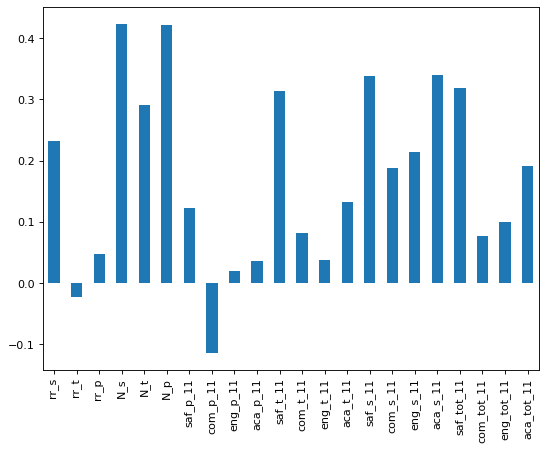

In [18]:
# Enables Jupyter to display graphs
%matplotlib inline

import matplotlib.pyplot as plt


# There are several fields in combined that originally came from a survey of parents, teachers, and students (ie. from 'survey_fields'). Make a bar plot of the correlations between these fields and sat_score.

plt.figure(figsize=(8, 6), dpi=80)  # adjust plot figure size
correlations[survey_fields].plot.bar()  # bar plots
plt.show()

#### Findings (Introduction):
From the above correlation barchart, we can review the strength of correlation between these factors, and SAT score.

Some factors that seem to have higher strength on correlation would include:
- Safety factors (eg. **saf_t_11** and **saf_s_11**)

## 2) Exploring Safety and SAT Scores

Provided by: [Dataquest.io](https://www.dataquest.io/)

It would appear that **saf_t_11** and **saf_s_11**, which measure how teachers and students perceive safety at school, correlated highly with **sat_score**.

We'll dig into this relationship a bit more and try to figure out which schools have low safety scores.

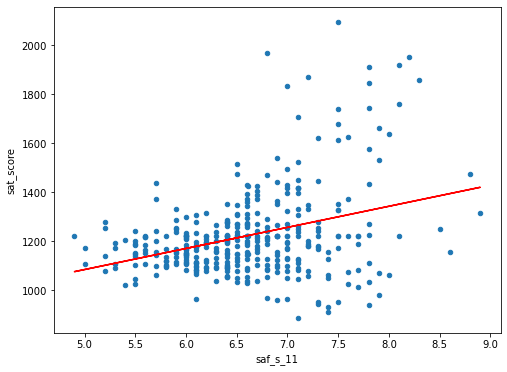

In [32]:
# Investigate safety scores
combined.plot(x='saf_s_11', y='sat_score', kind='scatter', figsize=(8, 6))  # scatterplot

# find line of best fit
# source: https://pythonguides.com/matplotlib-best-fit-line/
# using np.polyfit() method
import numpy as np

x = combined['saf_s_11']
y = combined['sat_score']

theta = np.polyfit(x, y, 1)
y_line = theta[1] + theta[0]*x  # representing best-fit line: y = mx + C

# add line of best fit to plot
plt.plot(x, y_line, color='red')

# show plot
plt.show();

#### Findings (Exploring Safety And SAT Scores):

It does appear from the scatterplot above that there is a positive correlation best-fit-line that trends gradually upwards, between safety scores and SAT scores.

## 3) Exploring Race And SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

- **white_per**
- **asian_per**
- **black_per**
- **hispanic_per**

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

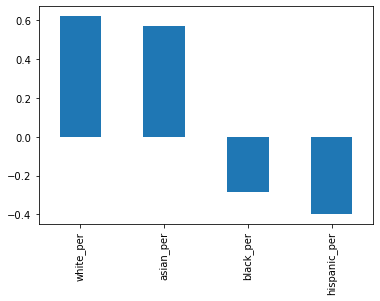

In [78]:
# Investigate racial differences in SAT scores.


# Make a bar plot of the correlations between the columns above and sat_score.
cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations[cols].plot(kind='bar')  # bar plot
plt.show()

#### Findings (Exploring Race And SAT Scores):
There are interesting correlations between SAT Scores and races percentages.

This could be an indication of racial disparity between SAT scores and races.

Correlations with SAT scores:
- Positive: **white_per, asian_per**
- Negative: **black_per, hispanic_per**


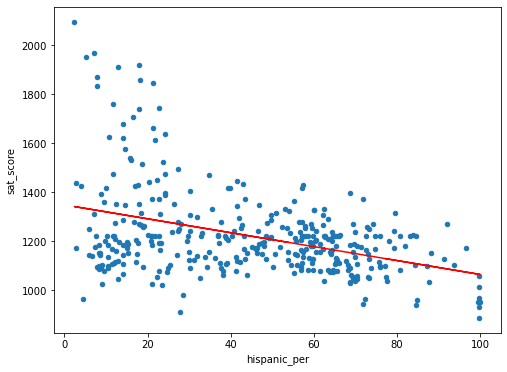

In [83]:
# Explore schools with low SAT scores and high values for hispanic_per.


combined.plot(x='hispanic_per', y='sat_score', kind='scatter', figsize=(8, 6))  # scatterplot


# find line of best fit
# source: https://pythonguides.com/matplotlib-best-fit-line/
# using np.polyfit() method
x = combined['hispanic_per']
y = combined['sat_score']

theta = np.polyfit(x, y, 1)
y_line = theta[1] + theta[0]*x  # representing best-fit line: y = mx + C

# add line of best fit to plot
plt.plot(x, y_line, color='red')

plt.show()

#### Findings (Exploring Race And SAT Scores):

We have confirmed with a scatterplot and line of best fit that there is a light but noticeable  negative correlation between SAT scores and hispanic students percentages.

In [ ]:
# Research any schools with a hispanic_per greater than 95%.


